## Feature Selection General approach

A)
1. Choose a classifier that you think might work well in that particular case and very loosely optimize hyperparameters, just to make sure you don't assign extremely bad values to some hyperparameters. This can often just be done by hand if you have a good intuitive understanding of your hyperparameters, or done with a very brief hyperparameter optimization procedure using just a bunch of features that you know to be decently good otherwise.

2. Feature selection, with hyperparameters that are maybe not 100% optimized but at least not extremely terrible either. If you have at least a somewhat decently configured machine learning algorithm already, having good features will be significantly more important for your performance than micro-optimizing hyperparameters. Extreme examples: If you have no features, you can't predict anything. If you have a cheating feature that contains the class label, you can perfectly classify everything.

3. Optimize hyperparameters with the features selected in the step above. This should be a good feature set now, where it actually may be worth optimizing hyperparams a bit.

The disadvantage of this approach is that we might have data leakage.

B) If we have time to optimize our model we can include feature selection in the cross validation process. This would be a better aproach as it would avoid data leakage.

## Feature Selection Techniques
1. Recursive Elemination with Cross Validation
2. Univariate Selection (SelectKBest commonly used)
3. SelectFromModel
4. Sequential Features Selection (Forward or Backward)
5. Feature Selection Tuning with Hyperparameters using Pipelines (best approach)

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
df=pd.read_csv('mobile_dataset.csv')
X=df.iloc[:,:-1]
y=df['price_range']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape # 20 total features

(1500, 20)

### 1. Recursive Elemination with Cross Validation

Using the feature_importance of the estimator that we specify it will rank the features from the most important to the least important. In each step it will decrease the nr of features by a specified value and perform cross validation. If the score of Cross Validation decreases it will stop decreasing the nr of features.

In [20]:
dic = {'battery_power': 1, 'px_height': 1, 'px_width': 1, 'ram': 1, 'pc': 2, 'talk_time': 3, 'sc_h': 4, 'mobile_wt': 5, 'int_memory': 6, 'sc_w': 7, 'n_cores': 8, 'fc': 9, 'm_dep': 10, 'touch_screen': 11, 'wifi': 12, 'clock_speed': 13, 'four_g': 14, 'three_g': 15, 'blue': 16, 'dual_sim': 17}
print(list(dic.keys()))
#plt.barh(width=ranking , y=feature_names)

['battery_power', 'px_height', 'px_width', 'ram', 'pc', 'talk_time', 'sc_h', 'mobile_wt', 'int_memory', 'sc_w', 'n_cores', 'fc', 'm_dep', 'touch_screen', 'wifi', 'clock_speed', 'four_g', 'three_g', 'blue', 'dual_sim']


In [21]:
# DYNAMIC

from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

def feature_selection_recursive_elemination_cv(model, X_train, y_train, X_test, scoring, step=1, min_features_to_select=1, 
                                               cv_kfold=5, verbose=False):
    try:
        print('Entered function feature_selection_recursive_elemination_cv.')

        total_nr_features = X_train.shape[1]
        selector = RFECV(model, step=step, min_features_to_select=min_features_to_select, cv=cv_kfold, scoring=scoring, 
                         n_jobs=-1, verbose=verbose)
        selector.fit(X_train, y_train)
        nr_features_selected = selector.n_features_
        
        dicti = {}
        for col, ranking in zip(X_train.columns, selector.ranking_):
            dicti[col] = ranking
        
        
        sorted_keys = sorted(dicti, key=dicti.get)
        sorted_dicti = {key: dicti[key] for key in sorted_keys}
        print('Features Ranking starting from the most important feature : ' + str(sorted_dicti))
        
        ranking = sorted_dicti.values()
        feature_names = list(sorted_dicti.keys())
        
        plt.barh(width=ranking, y=feature_names)
        plt.title("Feature Ranking (Rank 1 means Best Feature)")
        plt.xlabel('Ranking (Rank 1 means best feature)')
        plt.ylabel('Feature Names')
        plt.savefig('Feature_Importance.jpg')
        plt.show()
        
        
        cols_selected = X_train.columns[selector.support_]
        cols_removed = [col for col in X_train.columns if col not in cols_selected]
        print('Features Selected : ')
        print(cols_selected)
        print('Features Removed : ')
        print(cols_removed)
        
        new_X_train = X_train[cols_selected]
        new_X_test = X_test[cols_selected]
        
        
        print('Function feature_selection_recursive_elemination_cv Completed Successfully. Exited this function.')
        return new_X_train, new_X_test
    
    except Exception as e:
        print('Error occured in function feature_selection_recursive_elemination_cv. Error Message : ' + str(e))



Entered function feature_selection_recursive_elemination_cv.
Features Ranking starting from the most important feature : {'battery_power': 1, 'px_height': 1, 'px_width': 1, 'ram': 1, 'pc': 2, 'talk_time': 3, 'sc_h': 4, 'mobile_wt': 5, 'int_memory': 6, 'sc_w': 7, 'n_cores': 8, 'fc': 9, 'm_dep': 10, 'touch_screen': 11, 'wifi': 12, 'clock_speed': 13, 'four_g': 14, 'three_g': 15, 'blue': 16, 'dual_sim': 17}


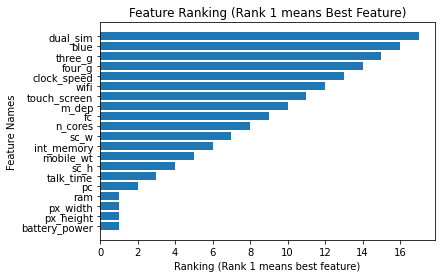

Features Selected : 
Index(['battery_power', 'px_height', 'px_width', 'ram'], dtype='object')
Features Removed : 
['blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']
Function feature_selection_recursive_elemination_cv Completed Successfully. Exited this function.


,battery_power,px_height,px_width,ram
650,1315,59,575,3278
1104,989,46,1069,1737
561,1229,120,1878,1667
643,920,1058,1421,2608
441,1654,1184,1719,1070


In [22]:
# Testing the function

new_X_train, new_X_test = feature_selection_recursive_elemination_cv(model=XGBRegressor(random_state=1), X_train=X_train, 
                                                                     y_train=y_train, X_test=X_test, 
                                                                     scoring='neg_mean_squared_error')

new_X_train.head()

### 2. Univariate Selection (SelectKBest commonly used)

Univariate feature selection works by selecting the best features based on univariate statistical tests. It will measure how strong is the relationship between independent and target feature and rank the features based on their score.

A) SelectKBest removes all but the  highest scoring features (select the top k most important features)

B) SelectPercentile removes all but a user-specified highest scoring percentage of features using common univariate statistical tests for each feature: false positive rate SelectFpr, false discovery rate SelectFdr, or family wise error SelectFwe.

C) GenericUnivariateSelect allows to perform univariate feature selection with a configurable strategy. This allows to select the best univariate selection strategy with hyper-parameter search estimator.

These objects take as input a scoring function that returns univariate scores and p-values (or only scores for SelectKBest and SelectPercentile):

Statistical test For regression: f_regression, mutual_info_regression

Statistical test For classification: chi2, f_classif, mutual_info_classif

* In this example i will use SelectKBest which is more common.

In [12]:
# DYNAMIC

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def feature_selection_univariate_selection(X_train, y_train, X_test, nr_features_to_select, score_func=chi2):
    try:
        print('Entered function feature_selection_univariate_selection.')
        total_nr_features = X_train.shape[1]
        print(total_nr_features)
        selector = SelectKBest(score_func=score_func, k=nr_features_to_select)
        ordered_feature = selector.fit(X_train, y_train)
    
        indices_of_selected_features = ordered_feature.get_support(indices=True)
        cols_selected = X_train.columns[indices_of_selected_features]
        nr_features_selected = len(cols_selected)
        print(cols_selected)
        
    
        new_X_train = pd.DataFrame(data=selector.transform(X_train), columns=cols_selected)
        new_X_test = pd.DataFrame(data=selector.transform(X_test), columns=cols_selected)
    
        dfscores=pd.DataFrame(ordered_feature.scores_,columns=["Score"])
        dfcolumns=pd.DataFrame(X_train.columns)
        features_rank=pd.concat([dfcolumns,dfscores],axis=1)
        features_rank.columns=['Features','Score']
        new_features_rank = features_rank.sort_values(by=['Score'], axis=0, ascending=False)
        new_features_rank.to_csv('Features_Ranking.csv', index=False)
  
        print('Function feature_selection_univariate_selection Completed Successfully. Exited this function.')
        return new_X_train, new_X_test 
    
    except Exception as e:
        print('Error occured in function feature_selection_univariate_selection. Error Message : ' + str(e))

In [13]:
# Testin the function

new_X_train, new_X_test = feature_selection_univariate_selection(X_train, y_train, X_test, nr_features_to_select=5, score_func=chi2)
new_X_train.head()

Entered function feature_selection_univariate_selection.
20
Index(['battery_power', 'mobile_wt', 'px_height', 'px_width', 'ram'], dtype='object')
Function feature_selection_univariate_selection Completed Successfully. Exited this function.


,battery_power,mobile_wt,px_height,px_width,ram
0,1315.0,128.0,59.0,575.0,3278.0
1,989.0,124.0,46.0,1069.0,1737.0
2,1229.0,191.0,120.0,1878.0,1667.0
3,920.0,149.0,1058.0,1421.0,2608.0
4,1654.0,146.0,1184.0,1719.0,1070.0


### 3. SelectFromModel
SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute (such as coef_, feature_importances_) or via an importance_getter callable after fitting. If the feature_importance is lower than the feature_importance threshold we specify, it is discarded, otherwise it will be selected.  <br>
It can be used with any ML Estimators that calculate coef_ like Lasso, or feature_importances_ like ExtraTreeClassifier, XGBoost etc.

We can perform Regularization using 3 different ML Estimators. <br>
A) Regularization with Linear Regression we use Lasso or ElasticNet. <br>
B) Regularization with Logistic Regression we use LogisticRegression(penalty='l1'). <br>
C) Regularization with Support Vector Machine we use LinearSCV(penalty='l1'). <br>

penalty : possible values 'l1', 'l2', 'elasticnet'. Usually for feature selection 'l1' and elastic net are used. <br>
solver : the algorithm to use in the optimization : possible values : ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’. Check sklearn documentation

In [20]:
# DYNAMIC 

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import ExtraTreeRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel


def feature_selection_SelectFromModel(X_train, y_train, X_test, model, threshold=None):
    try:
        print('Entered function feature_selection_SelectFromModel.')
        
        nr_total_features = X_train.shape[1]

        model.fit(X_train, y_train)

        selector = SelectFromModel(model, prefit=True, threshold=threshold)
        indices_selected_cols = list(selector.get_support(indices=True))
        cols_selected = X_train.columns[indices_selected_cols]
        nr_features_selected = len(cols_selected)
        print(cols_selected)

        new_X_train = pd.DataFrame(data=selector.transform(X_train), columns=cols_selected)
        new_X_test = pd.DataFrame(data=selector.transform(X_test), columns=cols_selected)
        
        # If estimator measures the feature importance feature_importance use this code to plot the feature importances 
        # if it uses other measurement like coef_ or others using this code will not work
        
        #ranked_features=pd.Series(model.feature_importances_,index=X_train.columns)
        #ranked_features.nlargest(10).plot(kind='barh')
        #plt.savefig('Feature_Ranking.jpg')
        #plt.show()
        
        print('Function feature_selection_SelectFromModel Completed Successfully. Exited this function')
        return new_X_train, new_X_test
    
    except Exception as e:
        print('Error occured in function feature_selection_SelectFromModel. Error Message : ' + str(e))

In [19]:
# Testing the function using ExtraTreesClassifier
# threshold will have default value

print(X_train.shape)
new_X_train, new_X_test = feature_selection_SelectFromModel(X_train, y_train, X_test, ExtraTreesClassifier())
print(new_X_train.shape)

(1500, 20)
Entered function feature_selection_SelectFromModel.
Index(['battery_power', 'ram'], dtype='object')
Function feature_selection_SelectFromModel Completed Successfully. Exited this function
(1500, 2)


In [21]:
# Testing the function using LinearSCV with L1 Regularization estimator

from sklearn.svm import LinearSVC

print(X_train.shape)
estimator = LinearSVC(C=0.01, penalty='l1', dual=False)
new_X_train, new_X_test = feature_selection_SelectFromModel(X_train, y_train, X_test, estimator)
print(new_X_train.shape)

(1500, 20)
Entered function feature_selection_SelectFromModel.
Index(['battery_power', 'clock_speed', 'dual_sim', 'fc', 'int_memory',
       'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h',
       'sc_w', 'talk_time'],
      dtype='object')
Function feature_selection_SelectFromModel Completed Successfully. Exited this function
(1500, 14)


In [22]:
# Testing the function using LogisticRegression with L1 Regularization estimator
# in case of regression we can use Linear Regression we use Lasso or ElasticNet

from sklearn.linear_model import LogisticRegression

print(X_train.shape)
estimator=LogisticRegression(penalty='l1', C=0.01, solver='liblinear')
new_X_train, new_X_test = feature_selection_SelectFromModel(X_train, y_train, X_test, estimator)
print(new_X_train.shape)

(1500, 20)
Entered function feature_selection_SelectFromModel.
Index(['battery_power', 'int_memory', 'mobile_wt', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'talk_time'],
      dtype='object')
Function feature_selection_SelectFromModel Completed Successfully. Exited this function
(1500, 10)


### 4. Sequential Feature Selector (SFS)

Sequential Feature Selection [sfs] (SFS) is available in the SequentialFeatureSelector transformer. SFS can be either forward or backward:

Forward-SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. Concretely, we initially start with zero feature and find the one feature (best feature) that maximizes a cross-validated score when an estimator is trained on this single feature (we train an ML Estimator using each single independent feature and select the one with highest cross validation score). Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the n_features_to_select parameter.

Backward-SFS follows the same idea but works in the opposite direction: instead of starting with no feature and greedily adding features, we start with all the features and greedily remove features from the set. The direction parameter controls whether forward or backward SFS is used.

In [33]:
from sklearn.feature_selection import SequentialFeatureSelector

def feature_selection_SFS(X_train, y_train, X_test, model, direction='forward', n_features_to_select=None,
                                      scoring=None, cv=None):
    try:
        print('Entered function feature_selection_SFS.')
        
        nr_total_features = X_train.shape[1]

        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=n_features_to_select, direction=direction, 
                                             scoring=scoring, cv=cv, n_jobs=-1)
        
        selector.fit(X_train, y_train)
        
        indices_selected_cols = list(selector.get_support(indices=True))
        cols_selected = X_train.columns[indices_selected_cols]
        nr_features_selected = len(cols_selected)
        print(cols_selected)

        new_X_train = pd.DataFrame(data=selector.transform(X_train), columns=cols_selected)
        new_X_test = pd.DataFrame(data=selector.transform(X_test), columns=cols_selected)
        
        # If estimator has feature_importance use this code to plot the feature importances 
        
        #ranked_features=pd.Series(model.feature_importances_,index=X_train.columns)
        #ranked_features.nlargest(10).plot(kind='barh')
        #plt.savefig('Feature_Ranking.jpg')
        #plt.show()
        
        print('Function feature_selection_SFS Completed Successfully. Exited this function')
        return new_X_train, new_X_test
    
    except Exception as e:
        print('Error occured in function feature_selection_SFS. Error Message : ' + str(e))


In [36]:
# Testing function using forward SFS
print(X_train.shape)
new_X_train, new_X_test = feature_selection_SFS(X_train, y_train, X_test, LogisticRegression(), direction='forward',
                                                n_features_to_select=7, scoring='roc_auc')
print(new_X_train.shape)

(1500, 20)
Entered function feature_selection_SFS.
Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory'],
      dtype='object')
Function feature_selection_SFS Completed Successfully. Exited this function
(1500, 7)


In [37]:
# Testing function using backward SFS
print(X_train.shape)
new_X_train, new_X_test = feature_selection_SFS(X_train, y_train, X_test, LogisticRegression(), direction='backward',
                                                n_features_to_select=7, scoring='roc_auc')
print(new_X_train.shape)

(1500, 20)
Entered function feature_selection_SFS.
Index(['ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi'], dtype='object')
Function feature_selection_SFS Completed Successfully. Exited this function
(1500, 7)


### 5. Feature Selection Tuning with Hyperparameters using Pipelines (best approach)

* Tuning Feature Selection and Hyperparameters at the same time. We will perform CV on all possible combinations of nr of features and hyperparameters and find best model.
* Advantage of this approach is that we are going to find the model with highest performance but the disadvantage is that it requires too much time for the tuning.

Like you already observed yourself, your choice of features (feature selection) may have an impact on which hyperparameters for your algorithm are optimal, and which hyperparameters you select for your algorithm may have an impact on which choice of features would be optimal.

So, yes, if you really really care about squeezing every single percent of performance out of your model, and you can afford the required amount of computation, the best solution is probably to do feature selection and hyperparamter tuning "at the same time". That's probably not easy (depending on how you do feature selection) though. The way I imagine it working would be like having different sets of features as candidates, and treating the selection of one set of features out of all those candidate sets as an additional hyperparameter.



In [23]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y= make_regression(n_samples=2000, n_features=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import RandomizedSearchCV

def feature_selection_hyperparameter_tuning(X_train, y_train, pipeline, params, scoring, cv=5, n_iter=20, verbose=False):
    try:
        print('Entered function feature_selection_hyperparameter_tuning.')
        
        infos = {}
    
        search = RandomizedSearchCV(pipeline, params, scoring=scoring, n_jobs=-1, n_iter=n_iter, cv=cv, verbose=verbose,
                                random_state=1)
        search.fit(X_train, y_train)
    
        infos['tuned_model'] = search.best_estimator_
        infos['best_cv_score'] = search.best_score_
        infos['best_hyperparameters_nr_features_selected'] = search.best_params_
    
        print('Function feature_selection_hyperparameter_tuning Completed Successfylly. Exited this function.')
        return infos
    
    except Exception as e:
        print('Error occured in function feature_selection_hyperparameter_tuning. Error Message : ' + str(e))
    

In [28]:
# Testing the function

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

# k=10 by default; k is the nr features selected
pipeline = Pipeline([('feature_selector', SelectKBest(score_func=f_regression, k=10)),
                     ('estimator', RandomForestRegressor(random_state=1))])

params = {'feature_selector__k' : [6, 8, 9, 11],
          'estimator__n_estimators' : [100, 300],
          'estimator__max_depth' : [6, 10]}

dic = feature_selection_hyperparameter_tuning(X_train, y_train, pipeline, params, scoring='r2')
dic

Entered function feature_selection_hyperparameter_tuning.


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Function feature_selection_hyperparameter_tuning Completed Successfylly. Exited this function.


{'tuned_model': Pipeline(steps=[('feature_selector',
                  SelectKBest(k=8,
                              score_func=<function f_regression at 0x000001481530C9D0>)),
                 ('estimator',
                  RandomForestRegressor(max_depth=10, n_estimators=300,
                                        random_state=1))]),
 'best_cv_score': 0.8219013932421891,
 'best_hyperparameters_nr_features_selected': {'feature_selector__k': 8,
  'estimator__n_estimators': 300,
  'estimator__max_depth': 10}}

### Comparisons

1. The advantage of RECV over SFS, SelectFromModel, SElectKBest is that they automatically select the top k best features for our model while for SFS, SelectFromModel, SelectKBest we have to specify the threshold/nr features we want to select which always seem to be a difficult decision.
2. SelectFromModel and SelectKBest is significantly faster than SFS and RECV. Indeed, SelectFromModel and SelectKBest only needs to fit a model once, while SFS and RECV needs to cross-validate many different models for each of the iterations. 
3. SFS and RECV however works with any model, while SelectFromModel requires the underlying estimator to expose a coef_ attribute or a feature_importances_ attribute. 
4. Comparison between Forward SFS and Backward SFS : The forward SFS is faster than the backward SFS if the nr of features is low, otherwise it is lower than the backward SFS. Suppose if we have total nr of features 20 and the top features that give best performance are 4. In this case forward SFS is faster because it will perform only 4 time CV while backward SFS would perform it 16 times. If top features that give best performance is 17, backward SFS is faster because it will perform cross validation only 3 times while forward SFS would perform it 17 times. So if we think we have more than 50% of features important we should better go for backward SFS to save some time, otherwise use Forward SFS.